In [295]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from flask import Flask, render_template
from sklearn.datasets import make_blobs 
from mpl_toolkits.mplot3d import Axes3D
import random
from itertools import groupby
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
import itertools
from functools import reduce
from itertools import product
from itertools import combinations
import scipy.stats as stats

In [296]:
class linucb_disjoint_arm():

        # each arm can have his own set of parameters (xi), this why we call it disjoint
    def __init__(self, arm_index, d, alpha,version):

        #Version of algorihtm
        self.version = version

        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = np.identity(d)
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])

        self.A_theta_list = []
        self.A_incertitude_list = []
        self.b_list = []
        self.theta_list = []
        self.ucb_evo = []
        self.alpha_list = []
                
    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression
            
        self.A_inv = np.linalg.inv(self.A) 

        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta is (d x 1) dimension vector
        
        self.theta = np.dot(self.A_inv, self.b) # each point of covariate estime une importance globale qu'accorde une arm à chaque feature
        #if self.version ==2 :
            #self.theta = self.theta / (sum(abs(self.theta))+0.0001) # <--------- AJOUT 
        # b est le poids qu'on pondère grace à la variance de x 

        # comme ca quand on a un datapoint on fait une regression avec ce teta (plus une deviation), ce nombre obtenu est l'importance
        # que peut donner un utilistauer 
        
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        
        # Find ucb based on p formulation (mean + std_dev) 
        # p is (1 x 1) dimension vector

        theta_x = np.dot(self.theta.T,x)
        incert_x =  self.alpha * np.sqrt(np.dot(x.T, np.dot(self.A_inv,x)))

        p = theta_x +   incert_x # !!TESTER AVEC DEUX X DIFFERENTS CE QUE CA DONNE!!
        
        # la récompense la plus haute espéré pour ce bras
        # et on rajouter la std pour l'exploration des arm qui ont une grande incertitude dans la variance de leur features 
        self.A_theta_list.append(self.A.copy())
        self.A_incertitude_list.append(self.A.copy())
        self.b_list.append(self.b.copy())
        self.theta_list.append(self.theta.copy())
        self.alpha_list.append(self.alpha)
        # -----------------
        return p , theta_x , incert_x
    
    
    def reward_update(self, reward, x_array):
        x = x_array.reshape([-1,1])
        self.A = np.add(self.A, np.dot(x, x.T))
        self.b = np.add(self.b, reward*x)
    

class linucb_policy():
    
    def __init__(self, K_arms, d, alpha,version):
        self.K_arms = K_arms
        self.version = version
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha,version = version) for i in range(K_arms)]
    
        
    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -10
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_ucb , theta_x , incert_x = self.linucb_arms[arm_index].calc_UCB(x_array)


            #indice = np.where(x_array == 1)[0][0]  
            indice = np.where((df_encoded.iloc[:, :df_encoded.shape[1]-1] == x_array).all(axis=1))[0][0] ##### @@@@@@ @@@@@@ @@@@@@ @@@@@@  
            indice = df_encoded.iloc[indice][-1] ##### @@@@@@ @@@@@@ @@@@@@ @@@@@@ @@@@@@ @@@@@@ 
            
            self.linucb_arms[arm_index].ucb_evo.append((indice,arm_ucb[0][0],theta_x[0][0],incert_x[0][0]))

            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                
                # Set new max ucb
                highest_ucb = arm_ucb
                
                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [(arm_index,arm_ucb)]

            # If there is a tie, append to candidate_arms
            elif arm_ucb == highest_ucb:
                candidate_arms.append((arm_index,arm_ucb))
        # Choose based on candidate_arms randomly (tie breaker)
        if candidate_arms==[]:
            print('PBBB')
            print(highest_ucb)
            print(candidate_arms)
        chosen_arm = [t[0] for t in candidate_arms]
        chosen_arm = np.random.choice(chosen_arm)
        
        return chosen_arm

In [292]:
def redimensionner(A,b,precision=2):
    for i in range(len(b)):
        x = b[i][0]/A[i][0]
        if A[i][0] > (10**(precision+1)) and x > 1/10**precision :# Very important precision+1 to avoid stagnation 
            div = math.ceil(x * 10**precision) / 10**precision
            b[i][0] = div*10**precision
            A[i][0] = 10**precision
    return A ,b


"""def redimensionner(A, b, precision=2):
    div = np.ceil(b[:, 0] / A[:, 0] * 10 ** precision) / 10 ** precision
    mask = (A[:, 0] > 10 ** (precision + 1)) & (div > 1 / 10 ** precision)
    A[mask, 0] = 10 ** precision
    b[mask, 0] = div[mask] * 10 ** precision
    return A, b
"""


def indice_norm(dict_composition_features):
    l = []
    cmpt = 0
    for v in dict_composition_features.values():
        l.append((cmpt,v+cmpt))
        cmpt = cmpt + v
    return l


def normaliser(theta):
    return ((theta / (np.sum(theta)+0.0000000001)) * 2) - 1


def normaliser_2(theta,dict_composition_features):
    L = indice_norm(dict_composition_features)
    final_theta = []
    for i in L:
        final_theta.append(normaliser(theta[i[0]:i[1]]))
    final_theta = np.concatenate(final_theta) 
    return final_theta / len(dict_composition_features)



class linucb_disjoint_arm():

    # each arm can have his own set of parameters (xi), this why we call it disjoint
    def __init__(self, arm_index, d, alpha,version):

        #Version of algorihtm
        self.version = version

        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A_incertitude = np.ones((d, 1))
        self.A_theta = np.ones((d, 1))
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])

        self.A_theta_list = []
        self.A_incertitude_list = []
        self.b_list = []
        self.theta_list = []
        self.ucb_evo = []
        self.alpha_list = []
                
    def calc_UCB(self, x_array):
            
        self.A_inv_incertitude = np.reciprocal(self.A_incertitude )
        self.theta = np.divide(self.b,self.A_theta)


        x = x_array.reshape([-1,1])

        

        incertitude = np.sqrt(np.dot( (self.A_inv_incertitude).T,x)[0][0])

        theta = np.dot(normaliser_2(self.theta,dict_composition_features).T,x)[0][0]

        p = theta +   self.alpha * incertitude
        
        # la récompense la plus haute espéré pour ce bras
        # et on rajouter la std pour l'exploration des arm qui ont une grande incertitude dans la variance de leur features 
        self.A_theta_list.append(self.A_theta.copy())
        self.A_incertitude_list.append(self.A_incertitude.copy())
        self.b_list.append(self.b.copy())
        self.theta_list.append(normaliser_2(self.theta,dict_composition_features))
        self.alpha_list.append(self.alpha)
        # -----------------
        
        return p , theta , self.alpha * incertitude
     
    def reward_update(self, reward, x_array):
        # Reshape covariates input into (d x 1) shape vector        
        x = x_array.reshape([-1,1])
        self.A_incertitude = np.add(self.A_incertitude, x)
        self.A_theta = np.add(self.A_theta, x)
        self.b = np.add(self.b, reward*x)

        if self.version == 1 :
            self.A_theta,self.b = redimensionner(self.A_theta,self.b)

class linucb_policy():
    
    def __init__(self, K_arms, d, alpha,version):
        self.K_arms = K_arms
        self.version = version
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha,version = version) for i in range(K_arms)]
    
        
    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -10
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_ucb , theta , incert = self.linucb_arms[arm_index].calc_UCB(x_array)

           
            #indice = np.where(x_array == 1)[0][0]  
            indice = np.where((df_encoded.iloc[:, :df_encoded.shape[1]-1] == x_array).all(axis=1))[0][0] ##### @@@@@@ @@@@@@ @@@@@@ @@@@@@  
            indice = df_encoded.iloc[indice][-1] ##### @@@@@@ @@@@@@ @@@@@@ @@@@@@ @@@@@@ @@@@@@ 

            self.linucb_arms[arm_index].ucb_evo.append((indice,arm_ucb,theta,incert))

            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                
                # Set new max ucb
                highest_ucb = arm_ucb
                
                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [(arm_index,arm_ucb)]

            # If there is a tie, append to candidate_arms
            elif arm_ucb == highest_ucb:
                candidate_arms.append((arm_index,arm_ucb))
        # Choose based on candidate_arms randomly (tie breaker)
        if candidate_arms==[]:
            print('PBBB')
            print(highest_ucb)
            print(candidate_arms)
        chosen_arm = [t[0] for t in candidate_arms]
        chosen_arm = np.random.choice(chosen_arm)
        
        return chosen_arm


In [284]:
def ctr_simulator(K_arms, d, alpha, data_path):
    # Initiate policy
    linucb_policy_object = linucb_policy(K_arms = K_arms, d = d, alpha = alpha) # intialise les coefficienet A et b de chaque arme

    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    # Open data
    with open(data_path, "r") as f:

        for line_data in f:

            # 1st column: Logged data arm. 
            # Integer data type
            data_arm = int(line_data.split()[0])

            # 2nd column: Logged data reward for logged chosen arm
            # Float data type
            data_reward = float(line_data.split()[1])

            # 3rd columns onwards: 100 covariates. Keep in array of dimensions (100,) with float data type
            covariate_string_list = line_data.split()[2:]
            data_x_array = np.array([float(covariate_elem) for covariate_elem in covariate_string_list])

            # Find policy's chosen arm based on input covariates at current time step
            arm_index = linucb_policy_object.select_arm(data_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.
            if arm_index + 1 == data_arm:

                # Use reward information for the chosen arm to update
                linucb_policy_object.linucb_arms[arm_index].reward_update(data_reward, data_x_array)

                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += data_reward
                aligned_ctr.append(cumulative_rewards/aligned_time_steps)
                    
    return (aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object)

In [285]:
def simulate_reward(cluster_id,arm_id,nb_arm):
    penality = 0
    if cluster_id%nb_arm == arm_id: # in this case we choosed the good arm but doesn't mean for sure postive reward but high proba
        p = 0.6
        return random.choices([penality,1], [1-p,p])[0]
    else :
        p = 0.1
        return random.choices([penality,1], [1-p,p])[0]
    

In [286]:

def simulate_reward_shift(cluster_id,arm_id,nb_gps,nb_arm):
    prefered_arm =  shift(cluster_id,nb_gps)
    penality = 0
    if prefered_arm%nb_arm == arm_id: # in this case we choosed the good arm but doesn't mean for sure postive reward but high proba
        p = 0.6
        return random.choices([penality,1], [1-p,p])[0]
    else :
        p = 0.1
        return random.choices([penality,1], [1-p,p])[0]
    

def shift(c_id,nb_gps):
    t = (nb_gps-1) - c_id
    if (t<0 or t>nb_gps-1):
        print('erreur dans shift')
    return t


In [287]:
"""nb_gps = 50
for i in range(nb_gps):
    print('group ',i,' aime l arm ',i%10)
    print('group ',i,' aime l arm ',((nb_gps-1)-i)%10,' apres shift')"""

"nb_gps = 50\nfor i in range(nb_gps):\n    print('group ',i,' aime l arm ',i%10)\n    print('group ',i,' aime l arm ',((nb_gps-1)-i)%10,' apres shift')"

In [288]:
def calculate_alpha(aligned_ctr,t):
    tmp = np.var(aligned_ctr)
    if tmp ==0:
        tmp = tmp + 1
    tmp = np.log(abs(1/tmp))
    tmp = tmp/(np.mean(t))
    std = (max(t)-min(t))
    alpha = tmp-std
    t.append(alpha)
    return alpha 
    


def ctr_simulator(df, policy):
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    for i in range(len(df)):
        array = np.array(df.iloc[i])
        data_x_array = np.delete(array,-1) # enlève dernier élement 
        arm_index =  policy.select_arm(data_x_array) #random.randint(0, 2)
        data_reward = simulate_reward(array[-1],arm_index,policy.K_arms)
        # Use reward information for the chosen arm to update
        policy.linucb_arms[arm_index].reward_update(data_reward, data_x_array)
        # For CTR calculation
        aligned_time_steps += 1
        cumulative_rewards += data_reward
        aligned_ctr.append(cumulative_rewards/aligned_time_steps)
        ####################
        """ for i in range(policy.K_arms):
            policy.linucb_arms[i].alpha = calculate_alpha(aligned_ctr,t)"""
        ####################
        unaligned_ctr.append(cumulative_rewards)
        if (i%1000==0):
            print(i)
    return (unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr ,policy)


def ctr_simulator_shift(df, policy):
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
        
    for i in range(len(df)):
        array = np.array(df.iloc[i])
        data_x_array = np.delete(array,-1) # enlève dernier élement 
        arm_index = policy.select_arm(data_x_array)
        data_reward = simulate_reward_shift(array[-1],arm_index,len(df['cluster'].unique()),policy.K_arms)
        # Use reward information for the chosen arm to update
        policy.linucb_arms[arm_index].reward_update(data_reward, data_x_array)

        # For CTR calculation
        aligned_time_steps += 1
        cumulative_rewards += data_reward
        aligned_ctr.append(cumulative_rewards/aligned_time_steps)
        unaligned_ctr.append(cumulative_rewards)
        if (i%1000==0):
            print(i)
    return (unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, policy)



def afficher(aligned_time_steps,cumulative_rewards,aligned_ctr):
    print(aligned_time_steps)
    print(cumulative_rewards)
    plt.plot(aligned_ctr)
    print(aligned_ctr[-1])
    plt.show()


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
(30, 30)
19985
7486
0.3745809357017763


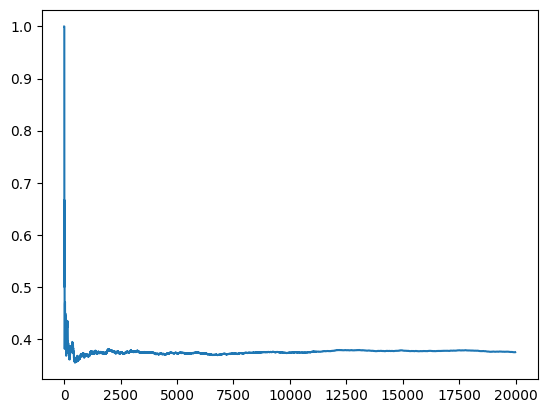

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
(30, 30)
19985
2613
0.13074806104578435


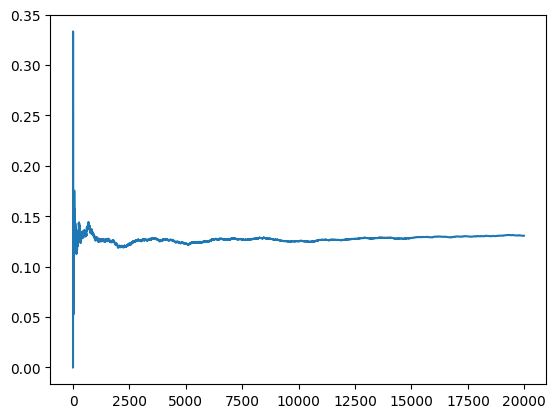

In [297]:
# METHODE 1
#Initialisation
linucb_policy_object = linucb_policy(K_arms = 10, d = df_encoded.shape[1]-1, alpha=1,version= -1)

unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_encoded,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_encoded,linucb_policy_object)


print(linucb_policy_object.linucb_arms[0].A.shape)
afficher(aligned_time_steps,cumulative_rewards,aligned_ctr)


unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_encoded,linucb_policy_object)

print(linucb_policy_object.linucb_arms[0].A.shape)
afficher(aligned_time_steps,cumulative_rewards,aligned_ctr)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
(30, 1)
19985
6270
0.31373530147610706


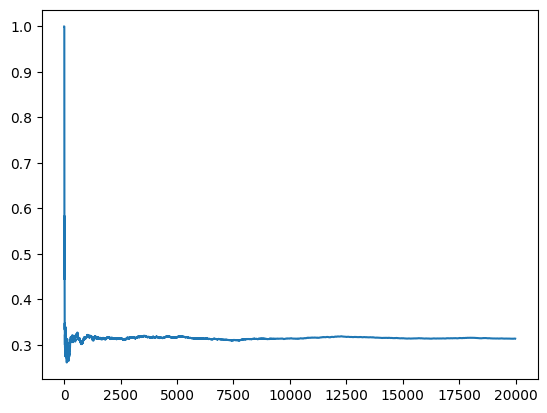

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
(30, 1)
19985
4514
0.22586940205153866


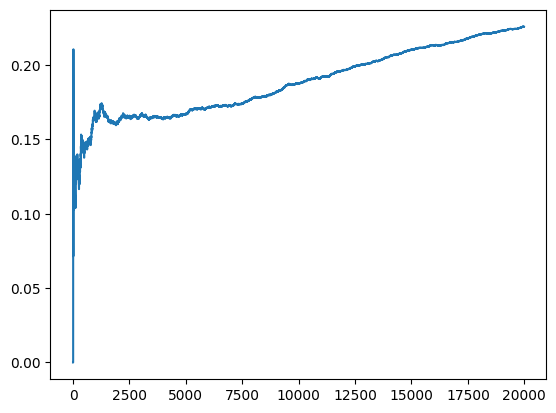

In [294]:
# METHODE 2
#Initialisation
linucb_policy_object = linucb_policy(K_arms = 10, d = df_encoded.shape[1]-1, alpha=0.5,version= 1)

unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object = ctr_simulator(df_encoded,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object = ctr_simulator(df_encoded,linucb_policy_object)


print(linucb_policy_object.linucb_arms[0].A_theta.shape)
afficher(aligned_time_steps,cumulative_rewards,aligned_ctr)


unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object = ctr_simulator_shift(df_encoded,linucb_policy_object)


print(linucb_policy_object.linucb_arms[0].A_theta.shape)
afficher(aligned_time_steps,cumulative_rewards,aligned_ctr)

In [2]:
def initiate_ucb_ev_dict(listt):
    result = {}
    for i in listt :
        result[i]={'p':[],'theta':[],'Incert':[]}
    return result


def evolution_paramètre_arm(arm_id,listt):
    arm_ucb_ev=linucb_policy_object.linucb_arms[arm_id].ucb_evo
    result=initiate_ucb_ev_dict( listt)
    for e in arm_ucb_ev:
        feature = e[0]
        result[feature]['p'].append(float(e[1]))
        result[feature]['theta'].append(float(e[2]))
        result[feature]['Incert'].append(float(e[3]))
    return result

arm = 0
fromm = 0
to = -1
listt = list(df_encoded['cluster'].value_counts().index)
result=evolution_paramètre_arm(arm,listt)
for i in listt:
    plt.plot(result[i]['Incert'][fromm:to], label='theta of group'+str(i))
plt.title("Evolution du Incert pour chaque feature de l'arm 0 ")
plt.legend()
plt.show()

for i in listt:
    plt.plot(result[i]['theta'][fromm:to], label='theta of group'+str(i))
plt.title("Evolution du theta pour chaque feature de l'arm 0 ")
#plt.legend()
plt.show()

for i in listt:
    plt.plot(result[i]['p'][fromm:to], label='theta of group'+str(i))
plt.title("Evolution du p pour chaque feature de l'arm 0 ")
#plt.legend()
plt.show()

# form de la courbe => racine(1/x)=1/racine(x)
# le alpha doit faire en sorte que incercitude doit etre dans le meme ordre de grandeur que theta



NameError: name 'df_encoded' is not defined

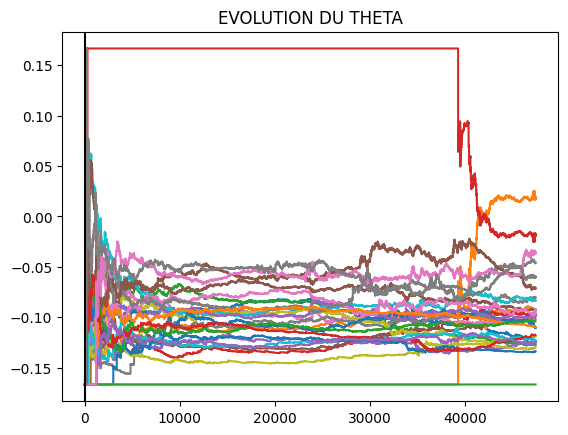

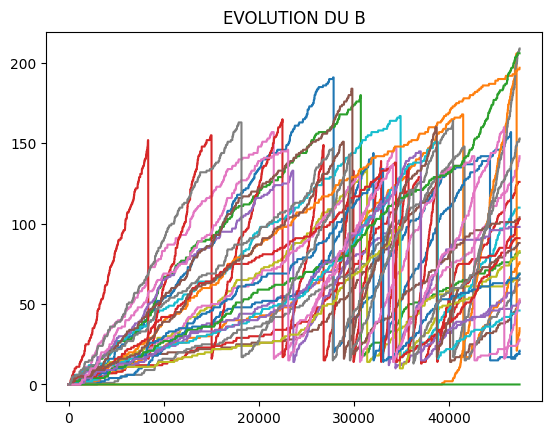

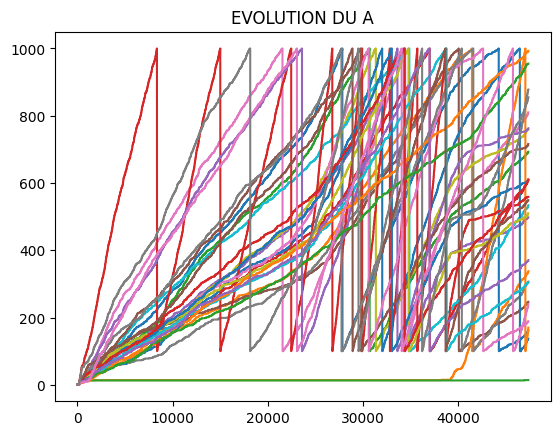

In [66]:
# Créer l'array de données
arm = 1
fromm = 0
to = -1
axe=0
dataT = np.array(linucb_policy_object.linucb_arms[arm].theta_list[fromm:to])
dataB = np.array(linucb_policy_object.linucb_arms[arm].b_list[fromm:to])
dataA = np.array(linucb_policy_object.linucb_arms[arm].A_theta_list[fromm:to])

# Afficher l'évolution de chaque point sur une courbe
for i in range(dataT.shape[1]):
    plt.plot(dataT[:,i,:], label='feature {}'.format(i))

#plt.legend()
plt.axvline(x=axe, color='black')
plt.title("EVOLUTION DU THETA")
plt.show()

# Afficher l'évolution de chaque point sur une courbe
for i in range(dataB.shape[1]):
    plt.plot(dataB[:,i,:], label='feature {}'.format(i))
#----
#plt.legend()
#plt.axvline(x=axe, color='black')
plt.title("EVOLUTION DU B")
plt.show()

# Afficher l'évolution de chaque point sur une courbe
for i in range(dataA.shape[1]):
    plt.plot(dataA[:,i,:], label='feature {}'.format(i))
#----
#plt.legend()
#plt.axvline(x=axe, color='black')
plt.title("EVOLUTION DU A")
plt.show()

#0 4 8 -> 3 7


In [298]:
def choix_compo_features(nb_feature,nb_min_categorie,nb_max_categorie):
    
    dict_composition_features = dict() # contient le nombre de catégorie pour chaque feature 
    columns = []
    nombre_individu_distinct = 1
    for i in range(nb_feature):
        feature = 'feature'+str(i)
        dict_composition_features[feature] = random.randint(nb_min_categorie, nb_max_categorie)
        columns.append(feature)
        nombre_individu_distinct = nombre_individu_distinct * dict_composition_features[feature]

    return dict_composition_features , nombre_individu_distinct

"""def genererate_data(nb_feature,nb_min_categorie,nb_max_categorie,nb_individu) :
    ## disctuer avec olivier sur la distribution des des categorie

    dict_composition_features , nombre_individu_distinct = choix_compo_features(nb_feature,nb_min_categorie,nb_max_categorie)

    # Initalisation du data frame 
    columns = ['feature'+str(f) for f in range(len(dict_composition_features))]
    df = pd.DataFrame(columns=columns)
    for i in range(nb_individu):
        nouvelle_ligne = {}
        for j in range(nb_feature):
            feature = 'feature'+str(j)
            nouvelle_ligne[feature] = random.randint(1, dict_composition_features[feature])
        df.loc[len(df)] = nouvelle_ligne
    return df , dict_composition_features , nombre_individu_distinct"""


"def genererate_data(nb_feature,nb_min_categorie,nb_max_categorie,nb_individu) :\n    ## disctuer avec olivier sur la distribution des des categorie\n\n    dict_composition_features , nombre_individu_distinct = choix_compo_features(nb_feature,nb_min_categorie,nb_max_categorie)\n\n    # Initalisation du data frame \n    columns = ['feature'+str(f) for f in range(len(dict_composition_features))]\n    df = pd.DataFrame(columns=columns)\n    for i in range(nb_individu):\n        nouvelle_ligne = {}\n        for j in range(nb_feature):\n            feature = 'feature'+str(j)\n            nouvelle_ligne[feature] = random.randint(1, dict_composition_features[feature])\n        df.loc[len(df)] = nouvelle_ligne\n    return df , dict_composition_features , nombre_individu_distinct"

In [299]:
def generer_des_groupes(dict_composition_features,nb_groupes):
    groupes = []
    for i in range(nb_groupes):
        groupe_i = []
        for feature in dict_composition_features:
            max = dict_composition_features[feature]
            nb = random.randint(1,max)
            groupe_i.append(random.sample(range(1,max+1), nb))
        groupes.append(groupe_i)
    return groupes

def nb_possibilite(groupes):
    return [reduce((lambda x, y: x * y), list(map((lambda x: len(x) ), g))) for g in groupes]

def distance(x,y):
    set1 = set(x)
    set2 = set(y)
    similarity = len(set1.intersection(set2)) / len(set1.union(set2))
    return 1 - similarity

def distance_groupes(x,y):
    l = [distance(x[i],y[i]) for i in range(len(x)) ]
    return sum(l) / len(l)

def distance_moyenne_entre_paires_groupes(groupes):
    cmpt = 0
    summ = 0
    list_dist = []
    for pair in itertools.combinations(list(range(len(groupes))), 2):
        cmpt = cmpt + 1
        tmp = distance_groupes(groupes[pair[0]],groupes[pair[1]])
        summ = summ + tmp
        list_dist.append((pair[0],pair[1],tmp))
    return summ/cmpt , list_dist


def appartenance_groupe(individu,groupes):
    ind=0
    indices = []
    for g in groupes:
        test = True
        for i in range(len(g)):
            if individu[i] not in g[i]:
                test = False
                break
        if test == True:
            indices.append(ind)
        ind=ind+1
    return indices


def nombre_individu_par_groupes(df,groupes):
    cmpt_gr = [0] * len(groupes)
    intersection_cmpt = [0] * len(groupes)
    sans = 0
    for i in range(len(df)):
        individu = list(df.iloc[i])
        L = appartenance_groupe(individu,groupes)
        if L == [] :
            sans = sans + 1
        else :
            intersection_cmpt[len(L)-1] = intersection_cmpt[len(L)-1] + 1
        for l in L :
            cmpt_gr[l] = cmpt_gr[l] + 1
    return cmpt_gr , intersection_cmpt, sans

def predict_nombre_individu_par_groupes_sum(taille_df,nombre_individu_distinct,nb_possibilite):
    tmp = nb_possibilite / nombre_individu_distinct
    return tmp * taille_df

def choisir_alea(L,nb):
    if len(L) - 1 >= nb :
        out_indices = random.sample(range(len(L)), nb)
    else : # len(L) - 1 < nb
        out_indices = random.sample(range(len(L)), len(L))
        

    return [L[i] for i in out_indices]

def generer_all_unique_possi_df(groupe, id_groupe,taille):
    columns = ['feature'+str(f) for f in range(len(groupe))]
    combinations = list(product(*groupe))
    combinations  = choisir_alea(combinations,taille)
    df = pd.DataFrame(combinations,columns=columns)
    df = df.assign(id_groupe = id_groupe)
    return df

def generer_all_unique_possi_df_for_groups(groupes,list_id,taille) :
    columns = ['feature'+str(f) for f in range(len(groupes[0]))]
    columns.append('id_groupe')
    df = pd.DataFrame(columns=columns)
    for i in list_id :
        tmp_df = generer_all_unique_possi_df(groupes[i], i,taille)
        df = pd.concat([df, tmp_df], axis=0)
    return df.reset_index().drop('index', axis=1)

def reblance_df(df,nb_groupes):
    # Et Avoir aussi au moins 10 rows, ca sera notre base pour entrainer le modèle 
    max_individu_grp = max(df['id_groupe'].value_counts())
    for id in range(nb_groupes) :
        nb_individu = (df['id_groupe']==id).sum()
        if(nb_individu<max_individu_grp):
            duppli =(max_individu_grp // nb_individu) - 1
            duppli_rand = max_individu_grp % nb_individu
            tmp_df = df[df['id_groupe']==id]
            if duppli > 0 :
                tmp_df = pd.concat([tmp_df] * duppli, ignore_index=True)
                tmp_df = pd.concat([tmp_df,tmp_df.sample(n=duppli_rand)], ignore_index=True)
            if duppli == 0:
                tmp_df = tmp_df.sample(n=duppli_rand)
            df = pd.concat([df,tmp_df], ignore_index=True)
    return df


def shape_train_df(df,nb_rows,len_group,ratio_balanced,dist='uniform'):
    distributions = {"expon": stats.expon(loc=0, scale=1),"poisson": stats.poisson(mu=1),"gamma": stats.gamma(a=1, loc=0, scale=1),"pareto": stats.pareto(b=1),"lognorm": stats.lognorm(s=1, loc=0, scale=1),"uniform": stats.uniform(loc=0, scale=1)}
    # Le ratio commun entre 0 et 1 est départagé equitablement entre les différents groupes puis le 1 - ratio_commun est departagé inequitablement pour le desequilibre
    if (ratio_balanced<0 or ratio_balanced>1 ):
        print("Ratio not between 0 and 1")
        return None 
    base_ratios = [ratio_balanced/len_group for i in range(len_group)]
    unblanced_ratio = 1 - ratio_balanced
    dist_ratios = distributions[dist].rvs(size=len_group)
    dist_ratios = dist_ratios / sum(dist_ratios)
    dist_ratios = sorted(dist_ratios, reverse=True)
    dist_ratios = [r * unblanced_ratio for r in dist_ratios]
    wanted_groups_number = [int((x + y)*nb_rows) for x, y in zip(base_ratios, dist_ratios)] 
    random.shuffle(wanted_groups_number) # MELANGER ALEA
    actual_groups_number = df['id_groupe'].value_counts()[0] 

    final_df = pd.DataFrame(columns=df.columns)

    for id_g  in range(len_group):
        wanted = wanted_groups_number[id_g]
        tmp_df = df[df['id_groupe']==id_g]
        if(wanted <= actual_groups_number):
            final_df = pd.concat([final_df,tmp_df.sample(n=wanted)],ignore_index=True)
        else :
            duppli =(wanted // actual_groups_number)
            duppli_rand = wanted % actual_groups_number
            tmp_df = pd.concat([tmp_df] * duppli, ignore_index=True)
            tmp_df = pd.concat([tmp_df,tmp_df.sample(n=duppli_rand)], ignore_index=True)
            final_df = pd.concat([final_df,tmp_df], ignore_index=True)
    
    return final_df 


def compter_diversite(df):
    num_groupes = list(df['id_groupe'].unique())
    disp = []
    for n in num_groupes :
        tmp_df = df[df['id_groupe']==n]
        tmp_df = tmp_df[tmp_df.columns[:-1]]
        prop = tmp_df.duplicated().sum() * 100 / len(tmp_df)
        disp.append((n,str(int(prop))+'% duplique',len(tmp_df) ) )
    return disp



In [341]:
def generete_data(nombre_feature,nombre_div_cat_min,nombre_div_cat_max,nombre_groupe,nb_lignes,ratio_de_disparite_inter_group,dist,encode,clustring):
    dict_info_data = {}
    dict_composition_features , nombre_individu_distinct = choix_compo_features(nombre_feature,nombre_div_cat_min,nombre_div_cat_max)
    dict_info_data['nb de col avec one hot'] = sum(dict_composition_features.values())
    dict_info_data['indiviud distinct'] = nombre_individu_distinct
    dict_info_data['composition des features'] = dict_composition_features
    ############################
    groupes = generer_des_groupes(dict_composition_features,nombre_groupe)
    moy , list_dist = distance_moyenne_entre_paires_groupes(groupes)
    nb_possi = nb_possibilite(groupes)
    dict_info_data['distance moyenne entre paires groupes'] = moy
    dict_info_data['nombre possibilite individu dans les groupes'] = nb_possi
    dict_info_data['distance entre paires groupes '] = list_dist
    ############################
    test = True
    while test :
        df = generer_all_unique_possi_df_for_groups(groupes,list(range(len(groupes))),20000) # ->>>>> A VARIER SI BESOIN SI BCP BCP DE LIGNES
        df = df.sample(frac=1).reset_index(drop=True)
        df.drop_duplicates(subset=list(df.columns[:-1]), keep='last', inplace=True)
        if len(df['id_groupe'].unique()) == len(groupes) : # ca veut dire un groupe inclu dans un autre et on veut pas ca , si egal ok
            test = False
            # Alors ok on peut passer étape suivante
    ############################
    df = reblance_df(df,len(groupes))
    final_df = shape_train_df(df,nb_lignes,len(groupes),ratio_de_disparite_inter_group,dist)
    dict_info_data['diversite des groupes'] = compter_diversite(final_df)
    ############################
    cmpt_gr , intersection_cmpt, sans= nombre_individu_par_groupes(final_df,groupes)
    dict_info_data['nb individu ds chaque groupes'] = cmpt_gr
    dict_info_data['nb de cross'] = intersection_cmpt
    ############################
    if encode == 1 :
        df_encoded = pd.get_dummies(final_df,columns=list(final_df.columns)[:-1]).astype(int)
        df_encoded['cluster']= df_encoded['id_groupe']
        df_encoded=df_encoded.drop('id_groupe',axis=1)
        df_encoded = df_encoded.sample(frac=1).reset_index(drop=True)

        dict_info_data['nombre d individu duplique en % dans final df'] =(df_encoded.duplicated().sum())*100/len(df_encoded)
        
        if  (df_encoded.shape[1] == sum(dict_composition_features.values()) + 1):
            return df_encoded , dict_info_data
        
        print('Il y aura probaleme de noramlisation dans méthode 2 dans dict_composition_features')
        return df_encoded , dict_info_data
    
    return final_df , dict_info_data



In [342]:
df_encoded , dict_info_data =generete_data(10,2,8,30,40000,0.5,'uniform',0,0)

In [343]:
df_encoded

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,id_groupe
0,1,1,2,6,3,1,2,1,3,2,0
1,6,1,2,6,3,1,2,5,3,8,0
2,6,1,2,6,3,7,2,7,3,3,0
3,1,1,2,6,3,1,2,6,3,2,0
4,6,1,2,6,3,1,2,3,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...
39977,4,2,3,5,3,2,1,6,2,5,29
39978,7,1,3,4,3,4,1,5,3,8,29
39979,4,2,3,2,3,5,1,2,2,3,29
39980,7,2,3,5,2,6,1,2,2,3,29


In [ ]:
dict_info_data['nombre d individu duplique en % dans final df']

In [344]:
list(dict_info_data.keys())

['nb de col avec one hot',
 'indiviud distinct',
 'composition des features',
 'distance moyenne entre paires groupes',
 'nombre possibilite individu dans les groupes',
 'distance entre paires groupes ',
 'diversite des groupes',
 'nb individu ds chaque groupes',
 'nb de cross']

KeyError: 'nombre d individu duplique en % dans final df'

In [346]:
dict_info_data['indiviud distinct']

5644800

In [347]:
dict_info_data['diversite des groupes']

[(0, '28% duplique', 780),
 (1, '0% duplique', 1637),
 (2, '0% duplique', 2310),
 (3, '1% duplique', 2057),
 (4, '0% duplique', 1172),
 (5, '0% duplique', 1696),
 (6, '0% duplique', 2070),
 (7, '34% duplique', 1636),
 (8, '6% duplique', 733),
 (9, '0% duplique', 974),
 (10, '49% duplique', 2160),
 (11, '11% duplique', 978),
 (12, '3% duplique', 1040),
 (13, '0% duplique', 826),
 (14, '10% duplique', 1341),
 (15, '0% duplique', 1557),
 (16, '18% duplique', 693),
 (17, '0% duplique', 1959),
 (18, '0% duplique', 2141),
 (19, '0% duplique', 1099),
 (20, '17% duplique', 1680),
 (21, '0% duplique', 946),
 (22, '0% duplique', 728),
 (23, '0% duplique', 836),
 (24, '3% duplique', 762),
 (25, '94% duplique', 2120),
 (26, '0% duplique', 967),
 (27, '0% duplique', 1240),
 (28, '0% duplique', 1030),
 (29, '0% duplique', 814)]

In [348]:
dict_info_data['nb de cross'][:4]

[33532, 6077, 369, 4]

In [300]:
dict_composition_features , nombre_individu_distinct = choix_compo_features(4,2,7)
print('nombre de colonne : ',sum(dict_composition_features.values()))
print('indiviud distinct : ',nombre_individu_distinct)
print(dict_composition_features)

nombre de colonne :  22
indiviud distinct :  588
{'feature0': 6, 'feature1': 7, 'feature2': 7, 'feature3': 2}


In [301]:
groupes = generer_des_groupes(dict_composition_features,30)
# un groupe represente un groupement de plusieurs type d'individu
# par exemple dans age on prend 30 et 40 et taille on prend grand et moyen , ceci represente un groupe
moy , list_dist = distance_moyenne_entre_paires_groupes(groupes)
nb_possi = nb_possibilite(groupes)
print("distance_moyenne_entre_paires_groupes : ",moy)
print("nombre possibilite d'individu dans les groupes : ",sum(nb_possi),nb_possi)

distance_moyenne_entre_paires_groupes :  0.5348056923918995
nombre possibilite d'individu dans les groupes :  2905 [252, 15, 72, 18, 45, 150, 144, 60, 72, 4, 140, 10, 16, 90, 252, 252, 84, 84, 224, 240, 6, 28, 224, 60, 30, 24, 35, 216, 8, 50]


In [323]:
df=generer_all_unique_possi_df_for_groups(groupes,list(range(len(groupes))),11520)#max(nb_possi)
df = df.sample(frac=1).reset_index(drop=True)
df.drop_duplicates(subset=list(df.columns[:-1]), keep='last', inplace=True)
len(df['id_groupe'].unique()) == len(groupes) # ca veut dire un groupe inclu dans un autre et on veut pas ca 

True

In [270]:
df = reblance_df(df,len(groupes))

In [275]:
final_df = shape_train_df(df,20000,len(groupes),0.5,dist='gamma')

In [276]:
compter_diversite(final_df)

[(0, '91% duplique', 368),
 (1, '76% duplique', 1275),
 (2, '74% duplique', 349),
 (3, '95% duplique', 723),
 (4, '94% duplique', 535),
 (5, '95% duplique', 404),
 (6, '52% duplique', 449),
 (7, '86% duplique', 545),
 (8, '74% duplique', 381),
 (9, '96% duplique', 1695),
 (10, '81% duplique', 365),
 (11, '87% duplique', 673),
 (12, '97% duplique', 423),
 (13, '80% duplique', 1105),
 (14, '0% duplique', 1396),
 (15, '98% duplique', 426),
 (16, '86% duplique', 378),
 (17, '92% duplique', 523),
 (18, '98% duplique', 1404),
 (19, '93% duplique', 645),
 (20, '55% duplique', 387),
 (21, '10% duplique', 524),
 (22, '66% duplique', 429),
 (23, '98% duplique', 1065),
 (24, '92% duplique', 420),
 (25, '90% duplique', 381),
 (26, '73% duplique', 744),
 (27, '17% duplique', 457),
 (28, '92% duplique', 637),
 (29, '74% duplique', 879)]

In [277]:
cmpt_gr , intersection_cmpt, sans= nombre_individu_par_groupes(final_df,groupes)
print("nombre d'individu dans chaque groupe : " , cmpt_gr)
print("nombre de cross : ",intersection_cmpt)

nombre d'individu dans chaque groupe :  [396, 2741, 1356, 835, 618, 409, 1856, 830, 747, 2388, 944, 1028, 479, 2357, 14253, 431, 845, 709, 1474, 807, 1292, 6333, 1533, 1453, 640, 712, 3114, 5187, 847, 1526]  total =  58140
nombre de cross :  [1911, 6235, 6259, 3660, 1347, 404, 169, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  total =  19985
nombre d'individu sans groupe :  0


In [278]:
final_df

,feature0,feature1,feature2,feature3,feature4,id_groupe
0,7,5,5,4,4,0
1,7,7,5,6,4,0
2,7,2,5,5,4,0
3,7,6,5,5,3,0
4,7,1,5,3,4,0
...,...,...,...,...,...,...
19980,5,3,2,3,3,29
19981,3,3,6,1,4,29
19982,5,6,4,1,4,29
19983,3,6,2,5,3,29


In [279]:
df_encoded = pd.get_dummies(final_df,columns=list(final_df.columns)[:-1]).astype(int)
df_encoded['cluster']= df_encoded['id_groupe']
df_encoded=df_encoded.drop('id_groupe',axis=1)
df_encoded = df_encoded.sample(frac=1).reset_index(drop=True)
df_encoded

,feature0_1,feature0_2,feature0_3,feature0_4,feature0_5,feature0_6,feature0_7,feature1_1,feature1_2,feature1_3,...,feature3_2,feature3_3,feature3_4,feature3_5,feature3_6,feature4_1,feature4_2,feature4_3,feature4_4,cluster
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,12
1,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,1,0,0,9
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,18
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,21
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19980,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,17
19981,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,26
19982,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,20
19983,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1


In [280]:
df_encoded.shape[1] == sum(dict_composition_features.values()) + 1 # ATTENTION VA AFFECTER NORMALISATION SINON

True

In [281]:
print(" nombre d'individu duplique en % " ,(df_encoded.duplicated().sum())*100/len(df_encoded))

 nombre d'individu duplique en %  77.11783837878409


14
15
16
17
18
19
20
21
22
23


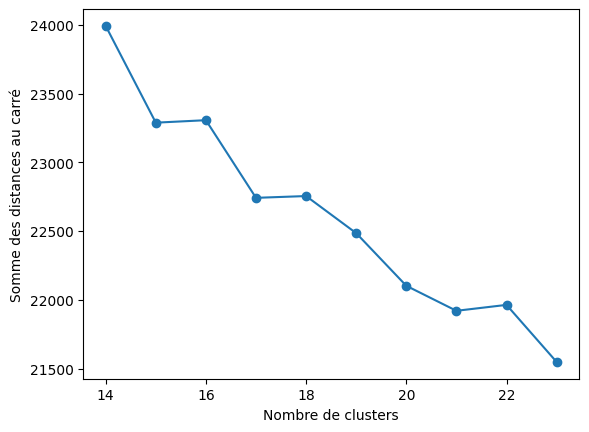

In [2121]:
from kmodes.kmodes import KModes
# Charger les données catégorielles depuis un fichier CSV
data = df
data = data.drop('id_groupe',axis=1)
data = data.sample(frac=1).reset_index(drop=True)

# Initialiser une liste vide pour stocker les valeurs de la somme des distances au carré
sse_cost = []
sse = []
# Tester différentes valeurs de k
min = 14
max = 23
for k in range(min, max+1):
    # Instancier l'algorithme K-modes avec le nombre de clusters souhaité
    km = KModes(n_clusters=k, init='Huang', n_init=5)
    
    # Effectuer le clustering sur les données
    km.fit(data)
    
    # Ajouter la somme des distances au carré à la liste
    sse_cost.append(km.cost_)
    sse.append(km)
    print(k)

# Afficher le graphique de la somme des distances au carré en fonction du nombre de clusters
plt.plot(range(min, max +1), sse_cost, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Somme des distances au carré')
plt.show()
